## Introduction


## Tutorial content
- [Installing the libraries](##Installing the libraries)
- [Web scrapping](##Web scrapping)
- [Data processing](##Data processing)

## Installing the libraries
To get start, you need to install some required libraries that we used.
### Bokeh
We used **Bokeh** to do the visualization, you need first install the **Bokeh** using the following command at a Bash or Windows Anacoda prompt:

````bash
conda install -c bokeh bokeh
````

## Loading the libraries

In [6]:
import numpy as np
import pandas as pd
import io, time, json
import requests
import pickle
import html
import pickle
import operator
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from multiprocessing import Pool
from pprint import pprint
from multiprocessing import Pool
from datetime import datetime
from pprint import pprint
from bs4 import BeautifulSoup
from pprint import pprint
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
%matplotlib inline

## Web scrapping
In this part, we scrapped data from different web resources and merged them together to be our final dataset. The movie information containing director, actors, budget and box office statistics are mainly from [the number website](https://www.the-numbers.com/). The web scrapper for the number is based on the [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) parsing the html page. It is not recommended to run all the web scrapping by yourself, since it is time-consuming.

The following is part of the web scrapping code. For all the web scrapping codes, please see this [python file](). To run the code, you will need to download the [python file]() and put it in same location with this jupyter notebook.

### Loading the web scrapping code

In [9]:
#load the web scrapping code
from movie import *

### Html parsing function

In [10]:
#This function is used to parse a html page of a movie in the thenumbers website given the html page
#given the html content, return the information as a dictionary
def parse_page(html_page, title):
    root=BeautifulSoup(html_page.decode('utf-8'), "html.parser")
    lis=dict()
    if title=="summary":
        #get the table tag of the movie details
        details = find_helper(root, 'h2', 'Movie Details')
        
        if details==None:
            return lis
        
        #get the information of the movie
        for item in details.find_all("tr"):
            first_child = item.contents[0]
            second_child = first_child.find_next_sibling()
            c_name = html.unescape(first_child.b.get_text()).replace(u'\xa0', u' ').replace('\n','').replace('\r','')
            if c_name.endswith('Budget:'):
                try:
                    lis['Budget'] = int(second_child.get_text().replace(u'\xa0', u' ').replace('\n','').replace('\r','').replace('$','').replace(',',''))
                except:
                    lis['Budget'] = html.unescape(second_child.get_text()).replace(u'\xa0', u' ').replace('\n','').replace('\r','')
                    pass
                
            elif c_name.startswith("Domestic"):
                text=second_child.prettify().split('<br/>')
                sub_dic=dict()
                for cate in text:
                    cate_temp = cate.split(')')[0].split('(')
                    date_data=html.unescape(cate_temp[0]).replace('<td>','').replace('\n','').replace('\r','').replace('by','').strip()
                    if len(date_data.split(','))>1:
                        date_type=date_data.split(',')[0][-2:]
                        try:
                            sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data, '%B %d'+date_type+', %Y')
                        except:
                            sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data, '%B, %Y')
                    else:
                        if len(date_data.split())==1:
                            sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data, '%Y')
                        else:
                            sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data.split()[1], '%Y')
                    
                lis['Domestic Releases'] = sub_dic
                
            elif c_name.startswith('International'):
                text = second_child.get_text().replace(u'\xa0', u' ').split('\n')
                sub_dic=dict()
                for cate in text:
                    cate_temp = cate.replace(')','').split('(')
                    if len(cate_temp)>2:
                        temp_key = cate_temp[2].strip()
                        if temp_key in sub_dic.keys():
                            temp_dic=sub_dic[temp_key]
                        else:
                            temp_dic=dict()
                        
                        date_data=html.unescape(cate_temp[0]).replace('<td>','').replace(u'\xa0', u' ').replace('\n','').replace('\r','').replace('Week of','').strip()
                        if len(date_data.split(','))>1:
                            date_type=date_data.split(',')[0][-2:]
                            try:
                                sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data, '%B %d'+date_type+', %Y')
                            except:
                                sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data, '%B, %Y')
                        else:
                            sub_dic[cate_temp[1].strip()] = datetime.strptime(date_data, '%Y')
                
                lis['International Releases']=sub_dic
            
            elif c_name.startswith('Video'):
                text=html.unescape(second_child.get_text()).replace(u'\xa0', u' ').replace('\n','').replace('\r','').split('by')
                if len(text[0].split(','))>1:
                    date_type=text[0].split(',')[0][-2:]
                    try:
                        lis['Video Release']=datetime.strptime(text[0].strip(), '%B %d'+date_type+', %Y')
                    except:
                        try:
                            lis['Video Release']=datetime.strptime(text[0].strip(), '%B, %Y')
                        except:
                            temp=text[0].split(',')
                            date_type=temp[0][-2:]
                            lis['Video Release']=datetime.strptime(temp[0]+','+temp[1], '%B %d'+date_type+', %Y')
                            
                else:
                    lis['Video Release']=datetime.strptime(text[0].strip(), '%Y')
                
                
            elif c_name.startswith('MPAA'):
                lis['MPAA Rating']=html.unescape(second_child.get_text()).replace(u'\xa0', u' ').replace('\n','').replace('\r','')
            
            elif c_name.startswith('Comparisons'):
                pass
            
            elif c_name.startswith('Keywords'):
                lis['Keywords']=second_child.get_text().replace(u'\xa0', u' ').split(',')
            
            elif c_name.startswith('Creative'):
                lis['Creative Type']=html.unescape(second_child.get_text()).replace(u'\xa0', u' ').replace('\n','').replace('\r','')
                
            elif c_name.startswith('Production Countries') or c_name.startswith('Production Companies'):
                lis[c_name.replace(':','')]=html.unescape(second_child.get_text()).replace(u'\xa0', u' ').split(',')
            
            elif c_name.startswith('Production Method'):
                lis['Production Method']=second_child.get_text().replace(u'\xa0', u' ').split('/')
                 
            else:
                lis[c_name.replace(':','')]=html.unescape(second_child.get_text()).replace(u'\xa0', u' ').replace('\n','').replace('\r','')
            pass
        

        #The column name
        title_name=['Record', 'Rank', 'Amount', 'Chart Date', 'Days In Release']
        
        #get the rank list
        lis['ranking on other records']=center_table_helper(root, title_name, 'h3', 'Ranking on other Records and Milestones')
                
    
    elif title=="box_office":
        #The column name
        title_name=['Record', 'Rank', 'Revenue']
        #get the demostic table information
        lis['demostic']=center_table_helper(root, title_name, 'h2', 'Domestic Cumulative Box Office Records')
        
        #get the weekend box office performance
        weekend_title=['Date', 'Rank', 'Gross', 'Change', 'Theaters', 'Per Theater', 'Total Gross', 'Week']
        lis['weekend']=table_helper(root, weekend_title, 'h2', 'Weekend Box Office Performance')
        
        #get the daliy box office performance
        daliy_title=['Date', 'Rank', 'Gross', 'Change', 'Theaters', 'Per Theater', 'Total Gross', 'Day']
        lis['daliy']=table_helper(root, weekend_title, 'h2', 'Daily Box Office Performance')
        
        #get the weekly box office performanc
        weekly_title=['Date', 'Rank', 'Gross', 'Change', 'Theaters', 'Per Theater', 'Total Gross', 'Week']
        
        lis['weekly']=table_helper(root, weekend_title, 'h2', 'Weekly Box Office Performance')
        pass
    
    
    elif title=="international":
        title_name=['Territory', 'Release Date', 'Opening Weekend', 'Opening Weekend Theaters', 'Maximum Theaters', 'Theatrical Engagements', 'Total Box Office', 'Report Date']
        #get the box office summary
        lis['Box Office Summary']= center_table_helper(root, title_name, 'h2','Box Office Summary Per Territory')
        
        title_name=['Record', 'Rank', 'Revenue']
        #get the international box office
        lis['International Box Office']=center_table_helper(root, title_name, 'h2', 'International Cumulative Box Office Records')
        
        title_name=['Record', 'Rank', 'Revenue']
        lis['Worldwide Box Office']=center_table_helper(root, title_name, 'h2', 'Worldwide Cumulative Box Office Records')
        pass
    
    
    elif title=="news":
        host_url="https://www.the-numbers.com"
        url_list=list()
        for item in root.find_all('a'):
            if item.get_text().replace(u'\xa0', u' ')=='More...':
                url_list.append(host_url+item.get('href'))
                
        text_list=list()
        for url in url_list:
            try:
                url_response=requests.get(url)
            except:
                continue
            url_html=url_response.content
            url_root=BeautifulSoup(url_html.decode('utf-8'), "html.parser")
            for div in url_root.find_all('div'):
                if div.get('id')=='news':
                    news_content=html.unescape(div.get_text()).replace('\n',' ').replace('\r', '').replace(u'\xa0', u' ')
                    text_list.append(news_content)
                    break

        lis['news']=text_list
        pass
    
    elif title=="cast":
        lis['leading_members']=cast_table_helper(root, 'h1', 'Lead Ensemble Members')
        lis['supporting_cast']=cast_table_helper(root, 'h1', 'Supporting Cast')
        lis['cameos']=cast_table_helper(root, 'h1', 'Cameos')
        lis['uncategorized']=cast_table_helper(root, 'h1', 'Uncategorized')
        lis['production']=cast_table_helper(root, 'h1', 'Production and Technical Credits')
        pass
            
    return lis

This function is to get all the information with the url of the movie info.

In [13]:
#given the url of the movie, get all the information of the movie
#https://www.the-numbers.com/movie/Black-Panther#tab=summary
def get_info(url):
    summary_url=url+"#tab=summary"
    international_url=url+"#tab=international"
    box_office_url=url+"#tab=box-office"
    news_url=url+"#tab=news"
    cast_url=url+"#tab=cast-and-crew"
    
    summary_response = requests.get(summary_url)
    international_response = requests.get(international_url)
    box_office_response = requests.get(box_office_url)
    news_response = requests.get(news_url)
    cast_response = requests.get(cast_url)
    summary_dic, international_dic, box_office_dic, news_dic, cast_dic = dict(), dict(), dict(), dict(), dict()
    
    if summary_response.status_code != 404:
        summary_dic = parse_page(summary_response.content, "summary")
        #pprint(summary_dic)
    
    if international_response.status_code != 404:
        international_dic = parse_page(international_response.content, "international")
        #pprint(international_dic)
    
    if box_office_response.status_code != 404:
        box_office_dic = parse_page(box_office_response.content, "box_office")
        #pprint(box_office_dic)
        
    if news_response.status_code !=404:
        news_dic=parse_page(news_response.content, "news")
        ##print(len(news_dic['news']))
        #pprint(news_dic)
        
    if cast_response.status_code!=404:
        cast_dic=parse_page(cast_response.content, "cast")
        #pprint(cast_dic)
        
    total_dic=dict()
    total_dic['summary']=summary_dic
    total_dic['international']=international_dic
    total_dic['box_office']=box_office_dic
    total_dic['news']=news_dic
    total_dic['cast']=cast_dic
    
    return total_dic

#get the movie information with the movie name(movie name+(year)), 
#this one will get the newest data through http request
def get_info_with_name(name):
    with open('name_url.pkl', 'rb') as f:
        name_dic = pickle.load(f)
    
    name_info=get_info(name_dic[name]['url'])
    
    return name_info

The function above will return a dictionary with all the movie information given the movie name. The dictioanry structure will follow the following pattern:
```
{"box_office": {"daliy": [{"Change":float,
                              "Date": datetime,
                              "Gross": int,
                              "Per Theater":int,
                              "Rank":int,  
                              "Theaters":int,  
                              "Total Gross": int,  
                              "Week":int},... ],    
                 "demostic": [{"Rank": int,
                              "Record": string,
                              "Revenue": int},...],
                 "weekend": [{"Change": float,
                             "Date": datetime,
                             "Gross": int,
                             "Per Theater": int,
                             "Rank": int,
                             "Theaters": int,
                             "Total Gross": int,
                             "Week": int},...],
                 "weekly": [{"Change": float,
                            "Date": datetime,
                            "Gross": int,
                            "Per Theater": int,
                            "Rank": int,
                            "Theaters": int,
                            "Total Gross": int,
                            "Week": int},...]},
   "cast": {"cameos": [{"name": string,
                      "url": string},...],
            "leading_members": [{"name": string,
                               "url": string},...],
            "production": [{"name": string,
                          "role": string,
                          "url": string},...],
            "supporting_cast": [{"name": string,
                               "url": string},...],
            "uncategorized": [{"name": string,
                             "url": string},...]},
   "international": {"Box Office Summary": [{"Maximum Theaters": int,
                                           "Opening Weekend": int,
                                           "Opening Weekend Theaters": int,
                                           "Release Date": datetime,
                                           "Report Date": datetime,
                                           "Territory": sting,
                                           "Theatrical Engagements": int,
                                           "Total Box Office": int},...],
                     "International Box Office": [{"Rank": int,
                                                 "Record": string,
                                                 "Revenue": int},...],
                     "Worldwide Box Office": [{"Rank": int,
                                             "Record": string,
                                             "Revenue": int},...]},
    "news": {"news": [string, ....]},
    "summary": {"Budget": int,
             "Creative Type": string,
             "Domestic Releases": {"IMAX": datetime,
                                   "Wide": datetime},
             "Franchise": string,
             "Genre": string,
             "International Releases": {location: {"Wide": datetime},...},
             "Keywords":[string,...],
             "MPAA Rating": string,
             "Production Companies": [string,...],
             "Production Countries": [string,...],
             "Production Method": [string,...],
             "Running Time": string,
             "Source": string,
             "Video Release": datetime,
             "ranking on other records": [{"Amount": int,
                                           "Chart Date": string,
                                           "Days In Release": int,
                                           "Rank": int,
                                           "Record": string},...]}                 
}
```

In [5]:
#An example to get the the movie infomation
pprint(get_info_with_name('Black Panther(2018)'))

{'box_office': {'daliy': [{'Change': 0.0,
                           'Date': datetime.datetime(2018, 2, 16, 0, 0),
                           'Gross': 75941146,
                           'Per Theater': 18891,
                           'Rank': 1,
                           'Theaters': 4020,
                           'Total Gross': 75941146,
                           'Week': 1},
                          {'Change': -0.13,
                           'Date': datetime.datetime(2018, 2, 17, 0, 0),
                           'Gross': 65995366,
                           'Per Theater': 16417,
                           'Rank': 1,
                           'Theaters': 4020,
                           'Total Gross': 141936512,
                           'Week': 2},
                          {'Change': -0.09,
                           'Date': datetime.datetime(2018, 2, 18, 0, 0),
                           'Gross': 60067439,
                           'Per Theater': 14942,
                 

                              'Revenue': 694254611},
                             {'Rank': 2,
                              'Record': 'All Time Domestic Non-Sequel Box '
                                        'Office',
                              'Revenue': 694254611},
                             {'Rank': 1,
                              'Record': 'Top 2018 Movies at the Domestic Box '
                                        'Office',
                              'Revenue': 694254611},
                             {'Rank': 1,
                              'Record': 'All Time Domestic Box Office for '
                                        'Based on Comic/Graphic Novel Movies',
                              'Revenue': 694254611},
                             {'Rank': 1,
                              'Record': 'All Time Domestic Box Office for Live '
                                        'Action Movies',
                              'Revenue': 694254611},
                       

                                           'Territory': 'Mexico',
                                           'Theatrical Engagements': 0,
                                           'Total Box Office': 28200000},
                                          {'Maximum Theaters': 110,
                                           'Opening Weekend': 1871014,
                                           'Opening Weekend Theaters': 105,
                                           'Release Date': datetime.datetime(2018, 2, 16, 0, 0),
                                           'Report Date': datetime.datetime(2018, 5, 7, 0, 0),
                                           'Territory': 'Netherlands',
                                           'Theatrical Engagements': 996,
                                           'Total Box Office': 9577924},
                                          {'Maximum Theaters': 143,
                                           'Opening Weekend': 1445803,
                        

                   '- Avengers: Infinity War Comparisons   C.S.Strowbridge ',
                   '  International Box Office: Rampage Retains Lead on '
                   'International Chart April 25th, 2018        Rampage '
                   'remained in first place on the international chart with '
                   '$58.0 million on 33,140 screens in 61 markets, for totals '
                   'of $217.6 million internationally and $283.3 million '
                   'worldwide. The studio’s share of this is very likely above '
                   'the film’s $120 million production budget, so it has an '
                   'excellent shot at breaking even early in its home market '
                   'run. The film’s biggest market of the weekend was China, '
                   'where it earned $27.07 million on 16,900 screens over the '
                   'weekend for a two-week total of $106.57 million. The film '
                   'has yet to open in France, Germany, and Japa

                   'film. On the high end, the film could earn $50 million '
                   'over four days. I’m going with $35 million / $45 million '
                   'over the three / four-day weekend.   Last Minute Update: '
                   'Warner Bros. announced Ready Player One earned $3.75 '
                   'million during its previews on Wednesday night. '
                   'Unfortunately, there are simply not enough films that '
                   'debut on Thursday to use this figure to make solid '
                   'predictions. G.I. Joe: Retaliation managed $2.6 million '
                   'back in 2013, but that’s not a good comparison, because it '
                   'was a sequel. It also earned terrible reviews and opened '
                   'during the more early days of regular previews. I do think '
                   'our original prediction is on the low end, so $45 million '
                   '/ $56 million is more likely.   Acrimony is the late

                   'over the weekend and, thanks to its Oscar win, it is not '
                   'done  yet.  Thoroughbreds earned just over $1 million '
                   'during its opening weekend.  The Shape of Water’s Oscar '
                   'win helped it get all the way to $60 million. By the end '
                   'of the weekend, it was in 47th place on the 2017 domestic '
                   'chart.   Weekend Box Office Results   C.S.Strowbridge ',
                   '  Weekend Wrap-Up: Black Panther and Wrinkle in Time have '
                   'Record-Breaking Weekend March 13th, 2018         For the '
                   'first time ever, the top two films at the weekend box '
                   'office were both directed by African-American directors. '
                   'That’s amazing and should be the big story. Unfortunately '
                   'for A Wrinkle in Time, the big story is Black Panther’s '
                   'continued box office dominance, as that

                   'three theaters, but on Saturday, it had special screenings '
                   'in over 400 theaters, earning nearly $200,000 in the '
                   'process. In the three theaters where it had regular '
                   'showings, it had a theater average of about $2,500. That’s '
                   'good for a film that has been in theaters for six '
                   'weeks.      The next best new limited release was '
                   'Operation Red Sea, which earned an average of $9,690 in 45 '
                   'theaters. There have been more than a few Chinese films to '
                   'do relatively well in limited release, so perhaps that '
                   'nation’s film industry can get a foothold here. The Young '
                   'Karl Marx was next with an average of $8,699 in three '
                   'theaters, which is also good for a foreign-language film. '
                   'Agent Mr. Chan was next with an average of $6,224 

                   'Comparisons   C.S.Strowbridge ',
                   '  Limited and VOD Releases: Monster Hits and Animated '
                   'Flicks February 16th, 2018         It’s a strange week for '
                   'limited releases with a wide variety of films to check '
                   'out. There’s an Oscar nominationed Russian film, Loveless. '
                   'As well as two Chinese films that are going to be monster '
                   'hits back home, Detective Chinatown 2 and Monster Hunt 2. '
                   'And finally, two animated films, Mind Game and Tehran '
                   'Taboo.     The Boy Downstairs - Reviews Zosia Mamet plays '
                   'Diana, a woman who returns to New York City after years '
                   'abroad. She finds the perfect apartment, only to learn '
                   'that her ex-boyfriend lives in the apartment just below '
                   'hers. The reviews are mixed, so it likely won’t find an '
     

                                           'Record': 'Biggest Domestic '
                                                     'Thursday'},
                                          {'Amount': 14688057,
                                           'Chart Date': datetime.datetime(2018, 2, 21, 0, 0),
                                           'Days In Release': 6,
                                           'Rank': 43,
                                           'Record': 'Biggest Domestic '
                                                     'Wednesday'},
                                          {'Amount': 20857361,
                                           'Chart Date': datetime.datetime(2018, 2, 20, 0, 0),
                                           'Days In Release': 5,
                                           'Rank': 11,
                                           'Record': 'Biggest Domestic '
                                                     'Tuesday'},
                           

## Data processing
We have scrapped 5517 movie information and save it in [the local pkl file](). You may need to download it and put in the same location as this jupyter notebook. 

In the following function,the statistical analysis is performed based on the movie information we scrapped. Movies with same genre, keyword, company and so on are counted. The result of the function is saved as pkl file and is put [here](). You can download them or you can run the following code.

In [21]:
#get the statistic information based on different categories
#may run several hours
def get_all_movie_categories():
    movie_categories=dict()
    keyword, genre, prod, creat, company, country, cast =dict(), dict(), dict(), dict(), dict(), dict(), dict()
    franchise=dict()
    person_name_url=dict()
    
    
    with open('movie_info.pkl', 'rb') as f:
        movie_info = pickle.load(f)
    
    for name, dic in movie_info.items():
        summary_dic = dic['summary']
        if 'Genre' in summary_dic.keys():
            genre[summary_dic['Genre'].strip()]=genre.get(summary_dic['Genre'].strip(),[])+[name]
        if 'Creative Type' in summary_dic.keys():
            creat[summary_dic['Creative Type'].strip()]=creat.get(summary_dic['Creative Type'].strip(),[])+[name]
        if 'Production Method' in summary_dic.keys():
            for mt in summary_dic['Production Method']:
                prod[mt.strip()]=prod.get(mt.strip(),[])+[name]
                #print(prod.get(mt,[]))
        if 'Production Companies' in summary_dic.keys():
            for cp in summary_dic['Production Companies']:
                company[cp.strip()]=company.get(cp.strip(),[])+[name]
        if 'Production Countries' in summary_dic.keys():
            for ct in summary_dic['Production Countries']:
                country[ct.strip()]=country.get(ct.strip(),[])+[name]
        if 'Keywords' in summary_dic.keys():
            for keywords in summary_dic['Keywords']:
                keyword[keywords.strip()]=keyword.get(keywords.strip(),[])+[name]
        if 'Franchise' in summary_dic.keys():
            franchise[summary_dic['Franchise'].strip()]=franchise.get(summary_dic['Franchise'].strip(),[])+[name]
                

        cast_dic = dic['cast']
        if 'production' in cast_dic.keys():
            for person in cast_dic['production']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
                temp_dict={'role': person['role'],'name': name}
                cast[person_name]=cast.get(person_name,[])+[temp_dict]
                    
        if 'leading_members' in cast_dic.keys():
            for person in cast_dic['leading_members']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
                        
        if 'supporting_cast' in cast_dic.keys():
            for person in cast_dic['supporting_cast']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
            
        if 'cameos' in cast_dic.keys():
            for person in cast_dic['cameos']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
                        
        if 'uncategorized' in cast_dic.keys():
            for person in cast_dic['uncategorized']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
        
    movie_categories['Genre']=genre
    movie_categories['Creative Type']=creat
    movie_categories['Production Method']=prod
    movie_categories['Production Companies']=company
    movie_categories['Production Countries']=country
    movie_categories['Keywords']=keyword
    movie_categories['Franchise']=franchise
    movie_categories['cast']=cast
    
    print('Writing...')
    with open('movie_categories.pkl', 'wb') as f:
        pickle.dump(movie_categories, f)
        
    with open('person_name_url.pkl', 'wb') as f:
        pickle.dump(person_name_url, f)
        
    return movie_categories

print(get_all_movie_categories().keys())

Writing...
dict_keys(['Genre', 'Creative Type', 'Production Method', 'Production Companies', 'Production Countries', 'Keywords', 'Franchise', 'cast'])


The above function will return the following structure:

```
{ "Genre": {keyword(genre name): [string(movie name),...],...},
  "Creative Type": {keyword(type name): [string(movie name),...],...},
  "Production Method":{keyword(method name): [string(movie name),...],...},
  "Production Companies":{keyword(company name): [string(movie name),...],...},
  "Production Countries":{keyword(country name): [string(movie name),...],...},
  "Franchise":{keyword(franchise name): [string(movie name),...],...},
  "Keywords":{keyword(keyword name): [string(movie name),...],...},
  "cast":{keyword(actor name): [string(movie name),...],...},
}
```
And a visualization of the movie genre distribution is shown as following

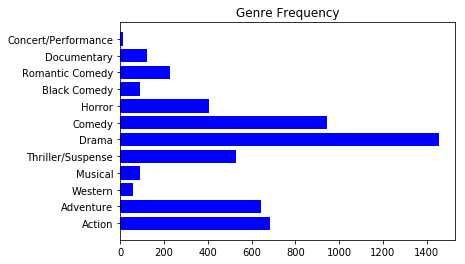

In [22]:
with open('movie_categories.pkl','rb') as f:
    cate_info=pickle.load(f)

dic=cate_info['Genre']
name_list =  list(dic.keys())
num_list = [len(a) for a in dic.values()]
plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
plt.title('Genre Frequency')
plt.show()

To convert text features like keywords, genre and movie staff to numeric information, we define the following way to calculate the influence factor of these features.

For example, the company feature, we model the average past box office performance the company produced as the influcence factor the company contribute to the final box office. The formula is as following:

$$
IF_i=log(\frac{\sum_{(i,j)\in D} BF_{j}}{|D_{(i,j)}|+0.1 }+1)
$$
where the $BF_j$ means the box office of movie $ M_j$.

$D_{(i,j)}$ means the company $C_i$ produced the movie $M_j$ in the dataset. 

The following is the code implementation and the visualization result.

[('Fairview Entertainment', 20.16510458271864), ('Kevin Feige', 20.188834252435928), ('Seven Bucks Productions', 20.196674530670407), ('DC Films', 20.206290199799334), ('John Calley', 20.211405000627998), ('Marvel Studios', 20.222776876389098), ('Steve Tisch Productions', 20.2420735023506), ('Esperanto Filmoj', 20.265466411578196), ('Ingenious Film Partners', 20.267055609994152), ('KatzSmith Productions', 20.267644437243806), ('Disney-Pixar', 20.281660856290824), ('Laura Ziskin Productions', 20.301337701538994), ('Tencent Pictures', 20.30207090709969), ('One Race Films', 20.320634559484038), ('Chris Meledandri', 20.326245639902215), ('Lucasfilm', 20.32877095859611), ('Simon Kinberg', 20.337419884892842), ('Wingnut Films', 20.346044102071257), ('Heyday Films', 20.35786380039569), ('Illumination Entertainment', 20.386172563069625), ('China Film Company', 20.409429556800788), ('Wanda Pictures', 20.42585515967782), ('Syncopy', 20.460710614331887), ('Fuji Television Network', 20.50784828028

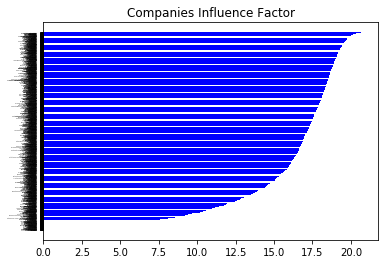

In [27]:
import math
with open('movie_info.pkl','rb') as f:
    movie_info=pickle.load(f)
    
with open('name_url.pkl','rb') as f:
    movie_budget=pickle.load(f)
    
def get_company_info_helper(name, movie_info=movie_info, movie_budget=movie_budget):
    
    company_name_info=dict()
    cast_dic=movie_info[name]['summary']
    if name in movie_budget.keys() and movie_budget[name]['Release Date']<datetime.now():
        if 'Production Companies' in cast_dic.keys():
            for company in cast_dic['Production Companies']:
                #print(name, company.strip())
                bo=movie_budget[name]['Worldwide Gross']
                company_name_info[company.strip()]=company_name_info.get(company.strip(),[])+[bo]
    
    return company_name_info

def get_all_company_info():
    with open('movie_info.pkl', 'rb') as f:
        movie_info=pickle.load(f)
    
    total_dic=dict()
    keys=list(movie_info.keys())
    pool = Pool(processes=10)
    pool_outputs = pool.map(get_company_info_helper,keys)
    pool.close()
    pool.join()
    
    for item in pool_outputs:
        for key, value in item.items():
            total_dic[key.strip()]=total_dic.get(key.strip(),[])+value
    
    #pprint(total_dic)
    company_info=dict()
    for key,value in total_dic.items():
        company_info[key]=math.log(np.sum(np.array(value))/(len(value)+0.1)+1)
    
    with open('company_info.pkl','wb') as f:
        pickle.dump(company_info, f)
        
    return    

get_all_company_info()
with open('company_info.pkl', 'rb') as f:
    company_info=pickle.load(f)

sorted_company=sorted(company_info.items(), key=lambda d: d[1])
print(sorted_company[-30:])

print(len(sorted_company))
target=sorted_company
name_list = [a[0] for a in target]
num_list = [a[1] for a in target]
plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
plt.tick_params(axis='y',labelsize=1)
plt.title('Companies Influence Factor')
plt.show()

Totally, there are 2739 companies. The top first company with the highest influence factor is B23, who produced Skyfall in 2012 together with Eon Productions, Metro-Goldwyn-Mayer Pictures and Columbia Pictures.

We did similar calculation of influence factors for movie staff, keywords, production method, franchise, creative type and genre. You can find all the code from [here]().

We selected budget, movie staff, keywords, production method, franchise, creative type, genre and production companies as the features to pass to our model. We exclude the movie with missing information and convert different features to the influence factor as we defined above.

In [3]:
visual_list=dict()

with open('movie_info.pkl', 'rb') as f:
    movie_info=pickle.load(f)
    
with open('person_info.pkl', 'rb') as f:
    person_info=pickle.load(f)
    
with open('name_url.pkl', 'rb') as f:
    movie_budget=pickle.load(f)

visual_y=list()
movie_name=list()
visual_list['budget']=list()
visual_list['cast']=list()
total_info=dict()
key_list=['Keywords', 'Production Method', 'Franchise', 'Creative Type', 'Genre', 'Production Companies']
for key in key_list:
    file_name='_'.join(key.lower().split())
    visual_list[file_name]=list()
    with open(file_name+'.pkl','rb') as f:
        total_info[file_name]=pickle.load(f)

for name in movie_info.keys():
    cast_dic=movie_info[name]['cast']
    cast_list=['leading_members', 'production']
    if name in movie_budget.keys() and movie_budget[name]['Release Date']<datetime.now():
        movie_name.append(name)
        test_value=math.log(movie_budget[name]['Worldwide Gross']+1)
        if test_value<15:
            visual_y.append('r')
        elif test_value<18:
            visual_y.append('b')
        else:
            visual_y.append('g')
            
        tmplist=list()
        for cate in cast_list:
            if cate in cast_dic.keys():
                for person in cast_dic[cate]:
                    person_name=person['name'].strip()
                    tmplist.append(person_info[person_name])
        
        visual_list['cast'].append(np.mean(np.array(tmplist)))
        visual_list['budget'].append(movie_budget[name]['Production Budget'])
        
        key_list=['Franchise', 'Creative Type', 'Genre']
        for key in key_list:
            file_name='_'.join(key.lower().split())
            if key in movie_info[name]['summary'].keys():
                cate=movie_info[name]['summary'][key].strip()
                visual_list[file_name].append(total_info[file_name][cate])
            else:
                visual_list[file_name].append(np.mean(np.array(list(total_info[file_name].values()) )))
        
        key_list=['Keywords', 'Production Method','Production Companies']
        for key in key_list:
            file_name='_'.join(key.lower().split())
            tmplist=list()
            if key in movie_info[name]['summary'].keys():
                for cate in movie_info[name]['summary'][key]:
                    tmplist.append(total_info[file_name][cate.strip()])
                visual_list[file_name].append(np.mean(np.array(tmplist)))
            else:
                visual_list[file_name].append(np.mean(np.array(list(total_info[file_name].values()) )))
                
P=np.array(list(visual_list.values())).T
column_name=np.array(list(visual_list.keys()))
visual_y=np.array(visual_y)
movie_name=np.array(movie_name)
movie_name=movie_name[~np.isnan(P).any(axis=1)]
y_train=visual_y[~np.isnan(P).any(axis=1)]
P=P[~np.isnan(P).any(axis=1)]
pdf=pd.DataFrame(data=P,index=movie_name, columns=column_name)
pdf.index.rename('name', inplace=True)
pdf.to_csv('movie_info.csv')

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Data visualization and analysis

In this part, we tried to visualize our dataset with different methods. In the first method, We tried to visualize the movie node with movie information as a 3-dimensional point. We used PCA to reduce the deminsion to 3 deminsion and label movies with different level of box office with different colors. The visualization is shown as following.

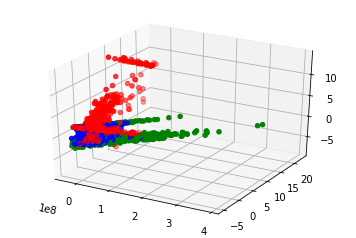

In [4]:
pca = PCA(n_components=3)
pca.fit(P)
P=pca.transform(P)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(P[:,0],P[:,1],P[:,2], c=y_train)
plt.show()

From the figure above, we can see that movies with the same level of box office approximately cluster together except for some outliers.

In another method, we tried to visualize the dataset as a network. We assume each row of data as a high-deminsional point and calculate the distance between each two points. If the distance is less than a threshold, we add an edge between the two points. The result is shown as following.

In [5]:
import networkx as nx

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx
import scipy.spatial.distance as sp
from sklearn.preprocessing import normalize

data=pd.read_csv('../movie_info.csv')
data=data.loc[:, data.columns != 'name'].as_matrix()
n=len(data)
threshold=100
dmatrix=np.zeros((n,n))
distance=sp.cdist(data,data)
print('starting')
for i in range(n):
    for j in range(n):
        if distance[i,j]<=threshold:
            dmatrix[i,j]=1

print('ending')
G=nx.from_numpy_matrix(dmatrix)
plot = figure(title="Network of Movie Nodes", x_range=(-0.2,0.2), y_range=(-0.2,0.2))

graph = from_networkx(G, nx.spring_layout, scale=3, center=(0,0))
plot.renderers.append(graph)

output_notebook()
print('visualizing')
show(plot)

starting
ending


Loading BokehJS ...

visualizing


/anaconda3/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


From the visualization above we can see that even though some movie nodes cluster together, overally the movie nodes are scattered. 

## Reference
